# Plot Scratchpad Results

## Prerequisites

In [23]:
import copy
import datetime
import importlib
import re

from pathlib import Path

import numpy as np
from tqdm import tqdm

import plotnine as p9

import pandas as pd
from collections import deque

from utils import add_src_to_sys_path

add_src_to_sys_path()

from common import wandb_utils, nest
from common import plotnine_utils as p9u

wandb_utils = importlib.reload(wandb_utils)
p9u = importlib.reload(p9u)

## Load the experiments

In [2]:
tags = ["presentation"]

In [3]:
plot_dir_name = "__".join(tags)
output_dir = Path("output_plots") / f"{plot_dir_name}"
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
df = wandb_utils.download_and_load_results(
    tags=tags,
    force_download=True,
)
len(df)

  0%|          | 0/401 [00:00<?, ?it/s]

Building dataframe...
Saving results to /Users/amirhosein/Development/PycharmProjects/len_gen/results/sanity_check.jsonl


401

In [6]:
scratchpad_config_pattern = re.compile(r"(.)*_scratchpad(.)+_ufs__(i._c._o._v._r.)_.*___.*")

overall_acc_pattern = re.compile(r"pred\/(\w+)_acc_(.+)")
scratchpad_acc_pattern = re.compile(r"pred\/(\w+)__(\w+)_(\w+)")


def get_split(key: str) -> str:
    if "test" in key:
        return "test"
    elif "valid" in key:
        return "validation"
    else:
        raise ValueError()


def get_category(ds, ds_split, key: str) -> int:
    if key == "overall":
        return -1
    if "-by-" in key:
        a, b = key.split("-by-")
        a, b = int(a), int(b)
        return max(a, b)
    else:
        return int(key)



xdf_data = deque()
for i, row in tqdm(df.iterrows(), total=len(df)):
    if row["job_type"] != "best_run_seed_exp":
        continue

    group = row["run_group"]

    scratchpad_config = "no_scratchpad"
    result = scratchpad_config_pattern.search(group)
    if result:
        scratchpad_config = result.group(3)

    dataset_name = row["cfg__dataset.name"]
    dataset_split = row["cfg__dataset.split"]
    dataset_pretty = wandb_utils.get_pretty_dataset_name(dataset_name, dataset_split)

    pe_name = wandb_utils.get_pretty_pe_name(row["cfg__model.position_encoding_type"])

    # Overall Accuracy
    for k, v in row.items():
        if np.all(pd.isnull(v)):
            continue
            
#         if k != "sum__pred/test_seq_acc":
#             continue

        if k.startswith("sum__pred/"):
            prediction_split = get_split(k)
            if "_acc_" in k:
                o = overall_acc_pattern.search(k)
                category = o.group(2)
                length = get_category(dataset_name, dataset_split, category)
                metric = "output_acc"
            else:
                k2 = k.replace("__overall", "_overall")
                o = scratchpad_acc_pattern.search(k)
                if o is None:
                    continue

                category = o.group(3)
                length = get_category(dataset_name, dataset_split, category)
                metric = o.group(2)

            # d = copy.deepcopy(row.to_dict())
            xdf_data.append({
                "scratchpad_config": scratchpad_config,
                "ds": dataset_name,
                "ds_split": dataset_split,
                "dataset_name": dataset_pretty,
                "pe": pe_name,
                "prediction_split": prediction_split,
                metric: float(v),
                "seq_length": length,
                "category": category
            })

oxdf = pd.DataFrame.from_records(xdf_data)
oxdf

100%|██████████| 401/401 [00:00<00:00, 1068.80it/s]


,scratchpad_config,ds,ds_split,dataset_name,pe,prediction_split,output_acc,seq_length,category
0,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.9220,26,26
1,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.6460,29,29
2,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.0000,39,39
3,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,validation,0.9872,16,16
4,no_scratchpad,s2s_copy,cmc2x_tr20_ts40,Copy (2x),No PE,test,0.1420,32,32
...,...,...,...,...,...,...,...,...,...
4915,no_scratchpad,s2s_copy,rsc_tr20_ts40,Copy (Repeat),No PE,validation,0.9973,8,8
4916,no_scratchpad,s2s_copy,rsc_tr20_ts40,Copy (Repeat),No PE,test,0.9960,30,30
4917,no_scratchpad,s2s_copy,rsc_tr20_ts40,Copy (Repeat),No PE,test,0.9940,31,31
4918,no_scratchpad,s2s_copy,rsc_tr20_ts40,Copy (Repeat),No PE,test,0.9980,23,23


## Plot LLM context window size

/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 15 x 8 in image.
/usr/local/miniconda3/envs/comp-gen_v2/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: output_plots/presentation/context_size.pdf


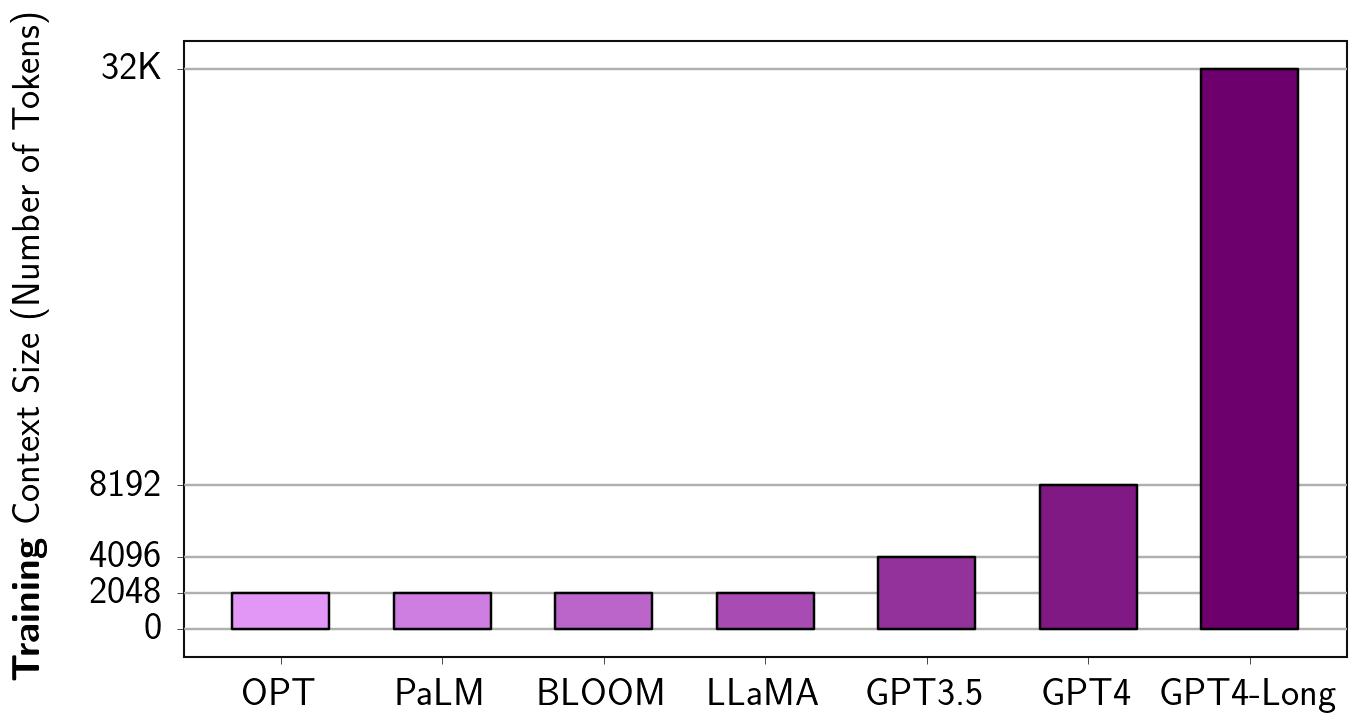

<ggplot: (8793513344413)>

In [58]:
from matplotlib import rc
rc('text', usetex=True)

pdf_data = {
    "llm": ["OPT", "PaLM", "BLOOM", "LLaMA", "GPT3.5", "GPT4", "GPT4-Long"],
    "context_size": [2048, 2048, 2048, 2048, 4096, 8192, 32000],
}
pdf = pd.DataFrame.from_dict(pdf_data)
pdf["llm"] = pdf["llm"].astype("category")
pdf["llm"] = pdf["llm"].cat.reorder_categories(["OPT", "PaLM", "BLOOM", "LLaMA", "GPT3.5", "GPT4", "GPT4-Long"])

p9 = importlib.reload(p9)

p = (
    p9.ggplot(pdf, p9.aes(x="llm", y="context_size", fill="llm"))
    + p9.geom_col(
        color="black",
        size=1,
        width=0.6,
    )
    + p9.scale_y_continuous(
        breaks=[0] + sorted(set(pdf["context_size"].tolist())),
        labels=["0"]+[str(c) if c != 32000 else str("32K") for c in sorted(set(pdf["context_size"].tolist()))],
#         expand = (0, 0)
    )
    + p9.labs(
        x=None,
        y=r"\textbf{Training} Context Size (Number of Tokens)",
        color=None,
        fill=None,
    )
    + p9u.scale_fill_prism("mila_purples_reverse")
#     + p9u.scale_color_prism("formal")
    #         + p9.theme_light()
    + p9u.theme_formal(grid="Y", axis_text_size=28, base_family="Computer Modern Sans serif")
#     + p9.theme_minimal()
#     + p9u.theme_ipsum(grid="XY", base_family="Times New Roman", axis_title_size=12, axis_text_size=12)
    + p9.theme(
        #             plot_margin=0,
#         text=p9.element_text(size=10),
#         panel_spacing=,
        legend_position="none",
        # legend_box="vertical",
        axis_title=p9.element_text(size=28),
        axis_title_y=p9.element_text(margin=dict(r=30)),
        figure_size=(15, 8),
    )
)
p.save(output_dir / f"context_size.pdf", dpi=300)
p

## Set Dataset

In [7]:
oxdf["ds"].unique()

array(['s2s_copy', 's2s_reverse'], dtype=object)

In [8]:
oxdf["ds_split"].unique()

array(['cmc2x_tr20_ts40', 'rsc2x_tr20_ts40', 'rdc_tr20_ts40',
       'cmc_tr20_ts40', 'mc2x_tr20_ts40', 'mcrv_tr20_ts40',
       'mc_tr20_ts40', 'rsc_tr20_ts40'], dtype=object)

In [9]:
xdf = oxdf
xdf = xdf[(xdf["pe"] != "Rotary (Fixed)")]
len(xdf)

4920